In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
result = json.load(open("eos_result/eos_result_batch.json"))
result1 = json.load(open("eos_result/tmp_result.json"))
for key in result:
    result[key] += result1[key]
eos_postions = result["eos_poss"]
eos_probabilities = result["eos_probabilities"]
df = pd.DataFrame(eos_postions).T
df_prob = pd.DataFrame(eos_probabilities).T

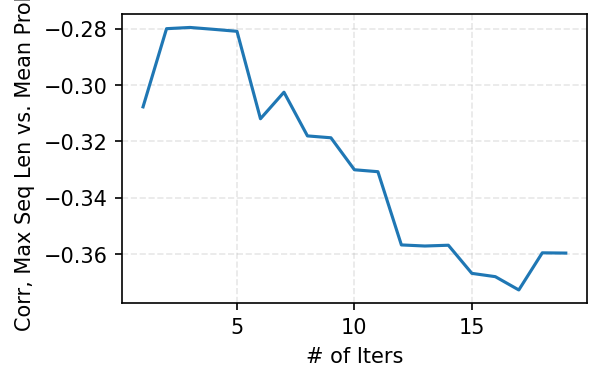

In [3]:
corrs = []
ratio = []
count = df.describe().T["count"]
for i in range(1, 20):
    df_eos_prob_count = df_prob[:i].describe().T[["count", "mean"]]
    df_eos_prob_count["count"] = count - i
    df_eos_prob_count = df_eos_prob_count[df_eos_prob_count["count"] > 0]
    ratio.append(df_eos_prob_count["count"]/df_eos_prob_count['mean'])
    corrs.append(df_eos_prob_count.corr(method="pearson").loc["mean", "count"])



plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(range(1, 20), corrs)
plt.xlabel("# of Iters")
plt.ylabel("Corr, Max Seq Len vs. Mean Prob")
plt.grid(alpha=0.3, linestyle="--")
# plt.savefig("fig/eos_corr.pdf")

         mean   count
0    0.000910   700.0
1    0.000932  1000.0
2    0.000936  1230.0
3    0.000938   820.0
4    0.000989   820.0
..        ...     ...
151  0.990332     0.0
152  0.994238     0.0
153  0.996925     0.0
154  0.998367     0.0
155  0.999790     0.0

[156 rows x 2 columns]


(0.0, 0.02)

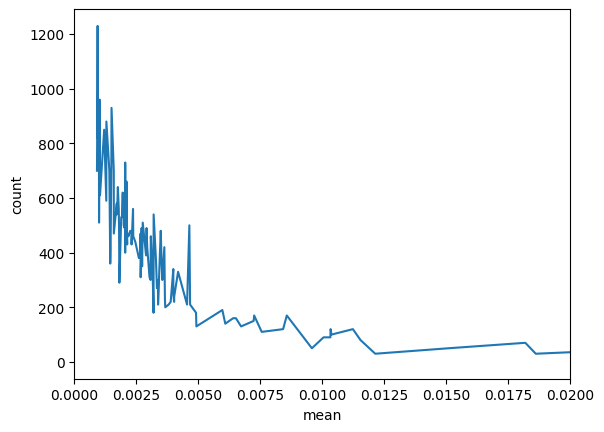

In [4]:
count_prob = df_prob.describe().T[["count", "mean"]]
count_prob['count']=count_prob['count']//10*10
count_prob_mean = count_prob.groupby(count_prob['mean']).mean().reset_index()
print(count_prob_mean)
count_prob_mean['ratio']=count_prob_mean['count']/count_prob_mean['mean']
sns.lineplot(data=count_prob_mean, x="mean",y="count")
plt.xlim(0,0.02)

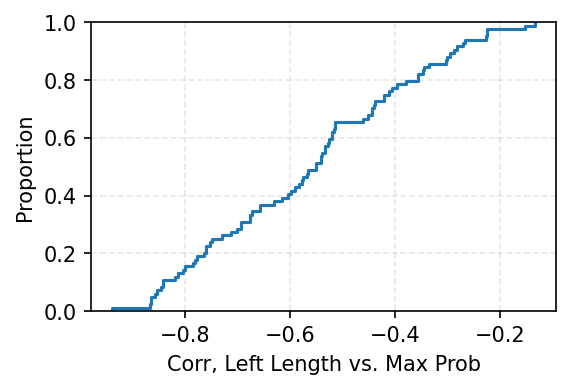

In [5]:
def get_left_count_corr(col):
    col = col[col > 0]
    left_ratio = []
    avg_probs = []
    for i in range(12, len(col)):
        left_ratio.append((len(col) - i))
        avg_probs.append(col.iloc[:i].max())
    tmp_df = pd.DataFrame({"left_ratio": left_ratio, "mean": avg_probs})
    corr = tmp_df.corr(method="pearson").loc["mean", "left_ratio"]
    return col.name, corr

plt.figure(figsize=(4, 2.5), dpi=150)
sns.ecdfplot(
    df_prob.apply(lambda col: get_left_count_corr(col), axis=0).T[1]
)
plt.xlabel("Corr, Left Length vs. Max Prob")
plt.grid(alpha=0.3, linestyle="--")

[0.05491382083856759, 0.06964067846328573, 0.06773956743980727, 0.05252663190530679, 0.04193618315345948, 0.04986089040058421, 0.04402188575061448, 0.03519164102956403, 0.026742421425122124, 0.021264938359431246, 0.014207168888294736, -0.0831894027051319, -0.08597135694957185, -0.08636898502975428, -0.13180926135023652, -0.14667781658317586, -0.15073113462985888, -0.15033332102940347, -0.1500256665053713, -0.12633197774952146, -0.1251997492888617, -0.12363935854200636, -0.12310232318237486, -0.020731268837295824, -0.06441528955489917, -0.06725972052555011, -0.0672946895874684, -0.045046907246122744, 0.054555215540873496]


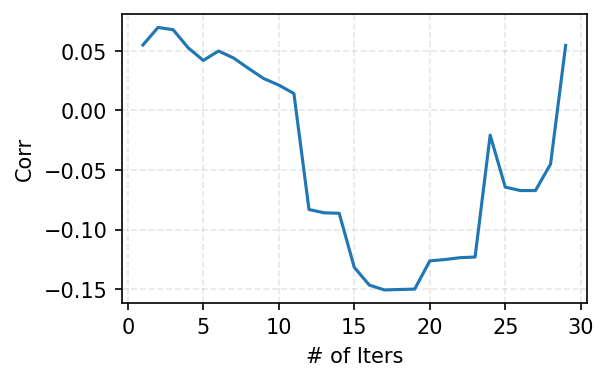

In [6]:
left_count_corr = df_prob.apply(lambda col: get_left_count_corr(col), axis=0).T
left_count_corr["index"] = left_count_corr[0].apply(lambda x: int(x))
left_count_corr["left_count_corr"] = left_count_corr[1]
count = df.describe().T["count"]
corrs = []
for i in range(1, 30):
    df_eos_prob_count = df_prob[:i].describe().T[["count", "mean"]]
    df_eos_prob_count["count"] = count - i

    df_eos_prob_count = df_eos_prob_count[
        df_eos_prob_count["count"] > 0
    ].reset_index()
    df_eos_prob_count = pd.merge(df_eos_prob_count, left_count_corr, on="index")
    # df_eos_prob_count["left_count_corr"] = left_count_corr
    corrs.append(
        df_eos_prob_count[["mean", "left_count_corr"]]
        .corr(method="pearson")
        .loc["mean", "left_count_corr"]
    )
print(corrs)
plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(range(1, 30), corrs)
plt.xlabel("# of Iters")
plt.ylabel("Corr")
plt.grid(alpha=0.3, linestyle="--")

In [7]:
df_eos_prob_count[["mean", "left_count_corr"]]

,mean,left_count_corr
0,0.000019,-0.379282
1,0.000006,-0.355833
2,0.000041,-0.344402
3,0.000431,NaN
4,0.000081,NaN
...,...,...
112,0.000085,-0.525378
113,0.000776,-0.598334
114,0.000082,-0.515208
115,0.000021,-0.551068


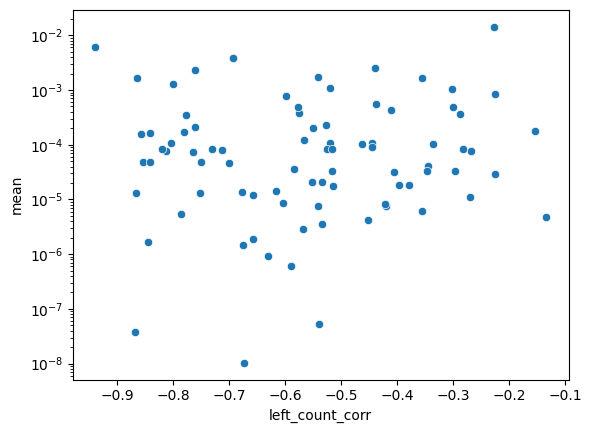

In [8]:
sns.scatterplot(df_eos_prob_count, x="left_count_corr", y="mean")
plt.yscale("log")

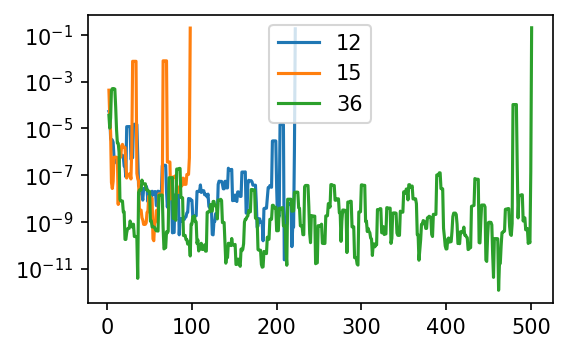

In [115]:
plt.figure(figsize=(4, 2.5), dpi=150)
rolling_mean_df_prob = df_prob.rolling(window=5, center=True).mean()
data = rolling_mean_df_prob.loc[:, [12,15,36]]
sns.lineplot(data=data, dashes=False)
plt.yscale("log")
# plt.ylim(0,50)